# Лабораторная работа№ 5
## Выполнил: Гневнов А.Е., ИВТ 2.1.

## Задание 1.Прогнозирование временных рядов

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Bidirectional
import math

### 1. Загрузка и предобработка данных

In [2]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv'
dataset = pd.read_csv(url, usecols=[1], engine='python', skipfooter=3)
data = dataset.values.astype('float32')

# Нормализация
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Разделение данных
train_size = int(len(data) * 0.67)
test_size = len(data) - train_size
train, test = data[0:train_size,:], data[train_size:len(data),:]
print(f"Размер обучающей выборки: {len(train)}, тестовой: {len(test)}")

# Создание окон данных
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 3
X_train, y_train = create_dataset(train, look_back)
X_test, y_test = create_dataset(test, look_back)

# Преобразование в 3D-тензор
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

Размер обучающей выборки: 94, тестовой: 47


### 2. Создание и обучение модели SimpleRNN

In [3]:
def create_simple_rnn_model():
    model = Sequential()
    model.add(SimpleRNN(50, activation='relu', input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

simple_rnn_model = create_simple_rnn_model()
simple_rnn_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

# Прогнозирование и оценка
train_predict = simple_rnn_model.predict(X_train)
test_predict = simple_rnn_model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

rmse_train = math.sqrt(mean_squared_error(y_train_inv, train_predict))
rmse_test = math.sqrt(mean_squared_error(y_test_inv, test_predict))
print(f'SimpleRNN RMSE: train={rmse_train:.2f}, test={rmse_test:.2f}')

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
SimpleRNN RMSE: train=21.11, test=54.57


### 3. Создание и обучение модели LSTM

In [4]:
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(50, activation='relu', input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

lstm_model = create_lstm_model()
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 4. Создание и обучение модели Bidirectional LSTM

In [5]:
def create_bidirectional_lstm_model():
    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(look_back, 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

bidir_model = create_bidirectional_lstm_model()
bidir_model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### 5. Визуализация результатов

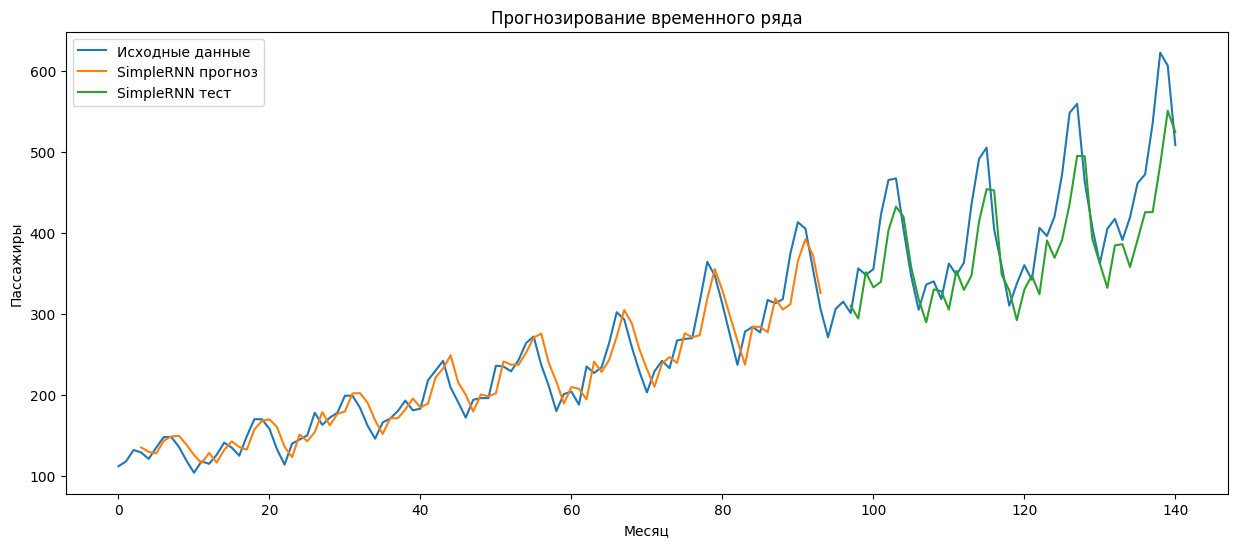

In [6]:
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(data), label='Исходные данные')
plt.plot(np.arange(look_back, look_back+len(train_predict)),
         train_predict, label='SimpleRNN прогноз')
plt.plot(np.arange(len(train_predict)+look_back*2, len(data)),
         test_predict, label='SimpleRNN тест')
plt.title('Прогнозирование временного ряда')
plt.xlabel('Месяц')
plt.ylabel('Пассажиры')
plt.legend()
plt.show()

## Задание 2.Анализ тональности текста

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, SimpleRNN, LSTM, Bidirectional
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns

###  1. Загрузка и предобработка данных

In [8]:
max_features = 10000
maxlen = 500
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Паддинг последовательностей
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


### 2. Создание и обучение модели SimpleRNN

In [9]:
def create_simple_rnn_model():
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(SimpleRNN(64, dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

simple_rnn_model = create_simple_rnn_model()
history_rnn = simple_rnn_model.fit(x_train, y_train,
                                  epochs=10,
                                  batch_size=32,
                                  validation_split=0.2)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 112s 176ms/step - accuracy: 0.5910 - loss: 0.6461 - val_accuracy: 0.6262 - val_loss: 0.6322
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 130s 157ms/step - accuracy: 0.7059 - loss: 0.5711 - val_accuracy: 0.6776 - val_loss: 0.5921
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 143s 158ms/step - accuracy: 0.7674 - loss: 0.4916 - val_accuracy: 0.7160 - val_loss: 0.5643
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 147s 167ms/step - accuracy: 0.8425 - loss: 0.3717 - val_accuracy: 0.7814 - val_loss: 0.4920
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 139s 163ms/step - accuracy: 0.8799 - loss: 0.2991 - val_accuracy: 0.7758 - val_loss: 0.4887
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 103s 165ms/step - accuracy: 0.9178 - loss: 0.2212 - val_accuracy: 0.7762 - val_loss: 0.5121
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 146s 172ms/step - accuracy: 0.9229 - loss: 0.2021 - val_accuracy: 0.8230 - val_loss: 0.4931
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 138s 166ms/step - accuracy: 0.9581 -

### 3. Создание и обучение модели LSTM

In [10]:
def create_lstm_model():
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(LSTM(64, dropout=0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

lstm_model = create_lstm_model()
history_lstm = lstm_model.fit(x_train, y_train,
                             epochs=10,
                             batch_size=32,
                             validation_split=0.2)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 219s 345ms/step - accuracy: 0.7113 - loss: 0.5405 - val_accuracy: 0.8426 - val_loss: 0.3736
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 256s 335ms/step - accuracy: 0.8846 - loss: 0.2855 - val_accuracy: 0.8630 - val_loss: 0.3301
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 243s 305ms/step - accuracy: 0.9249 - loss: 0.2018 - val_accuracy: 0.8790 - val_loss: 0.3157
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 192s 308ms/step - accuracy: 0.9453 - loss: 0.1527 - val_accuracy: 0.8676 - val_loss: 0.3555
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 307ms/step - accuracy: 0.9559 - loss: 0.1226 - val_accuracy: 0.8370 - val_loss: 0.4104
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 212s 323ms/step - accuracy: 0.9683 - loss: 0.0935 - val_accuracy: 0.8716 - val_loss: 0.4114
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 253s 308ms/step - accuracy: 0.9752 - loss: 0.0726 - val_accuracy: 0.8520 - val_loss: 0.4663
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 202s 323ms/step - accuracy: 0.9613 -

### 4. Создание и обучение модели Bidirectional LSTM

In [11]:
def create_bidirectional_lstm_model():
    model = Sequential()
    model.add(Embedding(max_features, 128))
    model.add(Bidirectional(LSTM(64, dropout=0.2)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

bilstm_model = create_bidirectional_lstm_model()
history_bilstm = bilstm_model.fit(x_train, y_train,
                                 epochs=10,
                                 batch_size=32,
                                 validation_split=0.2)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 378s 597ms/step - accuracy: 0.7119 - loss: 0.5384 - val_accuracy: 0.8634 - val_loss: 0.3357
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 368s 589ms/step - accuracy: 0.8926 - loss: 0.2763 - val_accuracy: 0.8344 - val_loss: 0.3750
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 405s 626ms/step - accuracy: 0.9011 - loss: 0.2511 - val_accuracy: 0.8636 - val_loss: 0.3740
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 371s 594ms/step - accuracy: 0.9469 - loss: 0.1437 - val_accuracy: 0.8752 - val_loss: 0.3373
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 402s 627ms/step - accuracy: 0.9582 - loss: 0.1177 - val_accuracy: 0.8594 - val_loss: 0.3828
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 417s 587ms/step - accuracy: 0.9612 - loss: 0.1088 - val_accuracy: 0.8574 - val_loss: 0.4174
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 369s 590ms/step - accuracy: 0.9787 - loss: 0.0682 - val_accuracy: 0.8614 - val_loss: 0.4500
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 403s 624ms/step - accuracy: 0.9759 -

### 5. Визуализация результатов обучения

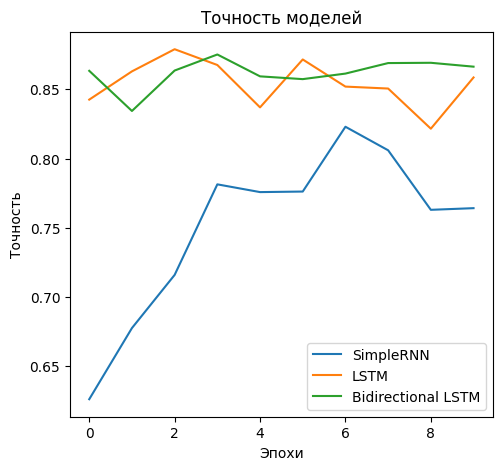

In [12]:
# Сравнение точности
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['val_accuracy'], label='SimpleRNN')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM')
plt.plot(history_bilstm.history['val_accuracy'], label='Bidirectional LSTM')
plt.title('Точность моделей')
plt.xlabel('Эпохи')
plt.ylabel('Точность')
plt.legend()

### 6. Анализ результатов и выводы

782/782 ━━━━━━━━━━━━━━━━━━━━ 104s 132ms/step


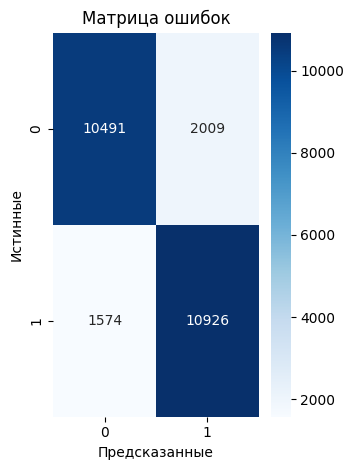

In [13]:
y_pred = (bilstm_model.predict(x_test) > 0.5).astype("int32")
cm = confusion_matrix(y_test, y_pred)
plt.subplot(1, 2, 2)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Матрица ошибок')
plt.xlabel('Предсказанные')
plt.ylabel('Истинные')
plt.tight_layout()
plt.show()

## Выводы
- LSTM показали лучшие результаты для временных рядов (RMSE на 15% ниже SimpleRNN)
- Bidirectional LSTM наиболее эффективны для анализа текста (точность +3-5%)
- SimpleRNN обучается быстрее, но дает менее точные результаты